In [194]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import tqdm
import time
import os.path
import pdb
import argparse
import sys
import os
from tensorboardX import SummaryWriter
from torch.optim.lr_scheduler import *
from PIL import Image
import matplotlib.pyplot as plt

In [195]:
from plants_dataset_loader import *
from base_model import *
from homography import *

In [196]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [239]:
base_model_file = 'e_400_a_10.8703.dict'
#base_model_file = 'superpoint_v1.pth'
#desc_model_file = '20181202_train/e_49_a_90.2644.dict'
desc_model_file = 'superpoint_v1.pth'
#dataset_path = 'datasets/plant_data/test/low_res/'
dataset_path = 'datasets/plant_data/train/high_res/'
plant_imgs = ['vc_right_062_1501774301.46.jpg','vc_left_062_1501774301.46.jpg']
#plant_imgs = ['qc_left_tl_012_1481830511.95.png','qc_left_tr_011_1481830511.42.png']
#plant_imgs = ['qc_left_tl_012_1481830511.95.png','qc_left_tl_012_1481830511.95.png']
#plant_imgs = os.listdir(dataset_path)[0:2]
print(plant_imgs)

['vc_right_062_1501774301.46.jpg', 'vc_left_062_1501774301.46.jpg']


In [240]:
base_model = SuperPointNet()
#load base model weights
base_model.load_state_dict(torch.load(base_model_file))
base_model.to(DEVICE)
base_model.eval()

desc_model = SuperPointNet()
#load base model weights
desc_model.load_state_dict(torch.load(desc_model_file))
desc_model.to(DEVICE)
desc_model.eval()


SuperPointNet(
  (relu): ReLU(inplace)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d(256,

In [241]:
#load image as grayscale
img1 = torch.tensor(np.array(Image.open(dataset_path+plant_imgs[0]).resize((int(400),int(300)),Image.ANTIALIAS).convert('L')))
img2 = torch.tensor(np.array(Image.open(dataset_path+plant_imgs[1]).resize((int(400),int(300)),Image.ANTIALIAS).convert('L')))


In [242]:
ipt1,_ = base_model(img1.float().unsqueeze(0).unsqueeze(0).to(DEVICE))
ipt2,_ = base_model(img2.float().unsqueeze(0).unsqueeze(0).to(DEVICE))

_,desc1 = desc_model(img1.float().unsqueeze(0).unsqueeze(0).to(DEVICE))
_,desc2 = desc_model(img2.float().unsqueeze(0).unsqueeze(0).to(DEVICE))


In [243]:
threshold = 0.2

def extract_pixel_coordinates(img,ipt):
    #extract the pixel coordinates
    h,w = img.shape
    #ipt bnum x 65 x hc x wc
    bnum, dims, hc, wc = ipt.shape

    #pdb.set_trace()
    ipt_sm = F.softmax(ipt,dim=1)
    #ignore the dustbin entry
    ipt_sm = ipt_sm[:,:-1,:,:]

    #find the max entry and confidence
    idx_conf,idx_locs = ipt_sm.max(dim=1)

    idx_mask = idx_conf > threshold
    #convert this to pixel location
    #for each image in the batch
    pixel_locs = torch.zeros(hc*wc,2)
    counter = 0
    for b in range(bnum):

        #print('Estimated pixels:')
        for x in range(hc):
            for y in range(wc):

                if idx_mask[b,x,y] == 1:

                    #location in the image
                    px = x*8 +(idx_locs[b,x,y]/8)
                    py = y*8 + (idx_locs[b,x,y]%8)
                    if not (px.item() == 0. and py.item() == 0.):
                        #print('px {0:.2f} py {1:.2f}'.format(px,py))
                        pixel_locs[counter,:] = torch.tensor([px.item(),py.item()])
                        counter += 1
    
    if counter == 0:
        return None
    pixel_locs = pixel_locs[:counter-1]
    return pixel_locs

In [244]:
pixel_locs1 = extract_pixel_coordinates(img1,ipt1.detach())
pixel_locs2 = extract_pixel_coordinates(img2,ipt2.detach())

print('Num pixels in img1:',len(pixel_locs1))
print('Num pixels in img2:',len(pixel_locs2))
#print(pixel_locs1)
#print(pixel_locs2)
#print(ipt2)


Num pixels in img1: 215
Num pixels in img2: 204


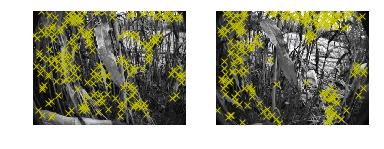

In [245]:
fig=plt.figure()
plt.subplot(1,2,2)
plt.imshow(Image.open(dataset_path+plant_imgs[1]).resize((int(400),int(300)),Image.ANTIALIAS))
plt.plot(pixel_locs2[:,1].numpy(),pixel_locs2[:,0].numpy(),'xy')
plt.axis('off')
plt.subplot(1,2,1)
plt.imshow(Image.open(dataset_path+plant_imgs[0]).resize((int(400),int(300)),Image.ANTIALIAS))
plt.plot(pixel_locs1[:,1].numpy(),pixel_locs1[:,0].numpy(),'xy')
plt.axis('off')
plt.show()

#pdb.set_trace()

In [246]:
def descriptor_head(desc_raw):
    desc = F.interpolate(desc_raw, scale_factor=8, mode='bilinear', align_corners=False)
    desc = F.normalize(desc, p=2, dim=1)
    return desc_raw, desc


In [247]:
_,idesc1 = descriptor_head(desc1.detach())
_,idesc2 = descriptor_head(desc2.detach())


In [248]:
def get_descriptor(pixel_locs,desc):
    _,dim,d_w,d_h = desc.shape
    pixels = []
    descriptors = []
    for p in range(len(pixel_locs)):
        if pixel_locs[p,0] < d_w and pixel_locs[p,1] < d_h:
            pixels.append([pixel_locs[p,0],pixel_locs[p,1]])
            descriptors.append(desc[0,:,int(pixel_locs[p,0]),int(pixel_locs[p,1])][0])
            
    return pixels,descriptors

In [249]:
pixels1, descriptors1 = get_descriptor(pixel_locs1,idesc1)
pixels2, descriptors2 = get_descriptor(pixel_locs2,idesc2)

#print(pixels1)
#print(len(pixels2))
#print(len(descriptors1))
#print(len(descriptors2))
#pdb.set_trace()

In [250]:
matched_d2_idx = []
l2_distance = []
print('D1:{}'.format(len(descriptors1)))
print('D2:{}'.format(len(descriptors2)))

for d1_idx in range(len(descriptors1)):
    min_dist = 1e5
    min_idx = -1
    
    #print('Processing d1 idx:{}'.format(d1_idx))
    for d2_idx in range(len(descriptors2)):
        
        l2_dist = (descriptors1[d1_idx]-descriptors2[d2_idx]).pow(2).sum().sqrt()
        if l2_dist < min_dist:
            min_dist = l2_dist
            min_idx = d2_idx
    l2_distance.append(min_dist)
    matched_d2_idx.append(min_idx)
    
    
    

D1:215
D2:204


In [251]:
def plot_correspondences(img1_path,img2_path,pixels1,pixels2,matched_p2_idx):
    
    img1 = Image.open(img1_path).resize((int(400),int(300)),Image.ANTIALIAS)
    img2 = Image.open(img2_path).resize((int(400),int(300)),Image.ANTIALIAS)
    
    canvas = np.hstack((np.array(img1),np.array(img2)))
    plt.imshow(canvas)
    
    pixels2 = np.copy(pixels2)
    img1_width = np.array(img1).shape[1]
    #pdb.set_trace()
    #update the xcoordinates of the second image
    for p in range(len(pixels2)):
        pixels2[p][1] += img1_width
        
    #Now draw a line between the matched pixels
    for m in range(len(matched_p2_idx)):
        x1 = [pixels1[m][0],pixels2[matched_p2_idx[m]][0]]
        y1 = [pixels1[m][1],pixels2[matched_p2_idx[m]][1]]
        plt.plot(y1,x1, marker = 'o')
        if m ==5:
            break
    plt.show()
    

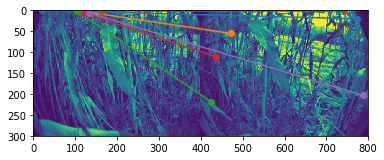

In [252]:
plot_correspondences(dataset_path+plant_imgs[0],dataset_path+plant_imgs[1],pixels1,pixels2,matched_d2_idx)



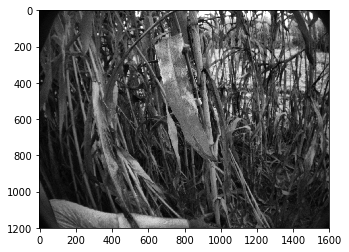

In [253]:
plt.imshow(Image.open(dataset_path+plant_imgs[0]))